In [6]:
from datetime import date, timedelta
import pandas as pd

# Tratamiento de datos
# ==============================================================================
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [7]:
sdate = date(2017,11,1)   # start date
edate = date(2022,4,30)   # end date

In [8]:
df_f = pd.date_range(sdate,edate-timedelta(days=1),freq='d').to_frame(index=False, name='Fecha')
df_f['target'] = 0
print(df_f.shape)
df_f.head()

(1641, 2)


,Fecha,target
0,2017-11-01,0
1,2017-11-02,0
2,2017-11-03,0
3,2017-11-04,0
4,2017-11-05,0


In [9]:
df_n = pd.read_csv('Nominas.csv', sep=';')
print(df_n.shape)
df_n.head()

(54, 1)


,Fecha
0,26/04/2022
1,26/03/2022
2,24/02/2022
3,27/01/2022
4,25/12/2021


In [10]:
df_n['Fecha'] = df_n['Fecha'].astype('datetime64')
df_n['target'] = 1
df_n.head()

C:\Users\JuanRamón\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '26/04/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\JuanRamón\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '26/03/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\JuanRamón\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '24/02/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  to_datetime(arr).values,
C:\Users\JuanRamón\AppData\Roaming\Python\Python310\site-packages\pandas\core\dtypes\cast.py:1163: UserWarning: Parsing '27/01/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent 

,Fecha,target
0,2022-04-26,1
1,2022-03-26,1
2,2022-02-24,1
3,2022-01-27,1
4,2021-12-25,1


In [11]:
df_f = df_f[~df_f['Fecha'].isin(df_n['Fecha'])]
print(df_f.shape)
df_f.head()

(1587, 2)


,Fecha,target
0,2017-11-01,0
1,2017-11-02,0
2,2017-11-03,0
3,2017-11-04,0
4,2017-11-05,0


In [12]:
df = pd.concat([df_f, df_n])
print(df.shape)
df.head()

(1641, 2)


,Fecha,target
0,2017-11-01,0
1,2017-11-02,0
2,2017-11-03,0
3,2017-11-04,0
4,2017-11-05,0


In [13]:
# Preparación del dato
# ==============================================================================
df = df.set_index('Fecha')
df = df.asfreq('D')
df = df.sort_index()
df.head()

,target
Fecha,
2017-11-01,0
2017-11-02,0
2017-11-03,0
2017-11-04,0
2017-11-05,0


In [14]:
print(f'Número de filas con missing values: {df.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


Fechas train : 2017-11-01 00:00:00 --- 2020-05-29 00:00:00  (n=941)
Fechas test  : 2020-05-30 00:00:00 --- 2022-04-29 00:00:00  (n=700)


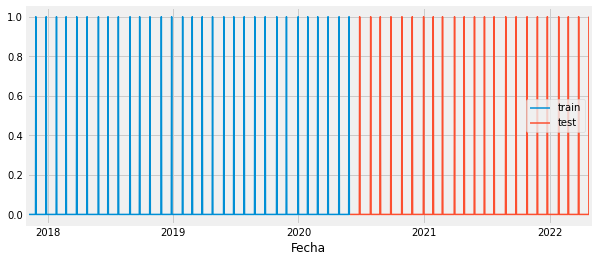

In [15]:
# Separación datos train-test
# ==============================================================================
steps = 700
df_train = df[:-steps]
df_test  = df[-steps:]

print(f"Fechas train : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Fechas test  : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
df_train['target'].plot(ax=ax, label='train')
df_test['target'].plot(ax=ax, label='test')
ax.legend();

In [16]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 365
             )

forecaster.fit(y=df_train['target'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 22

In [17]:
steps = 700
predicciones = forecaster.predict(steps=steps)
predicciones.head()

2020-05-30    0.00
2020-05-31    0.00
2020-06-01    0.19
2020-06-02    0.00
2020-06-03    0.00
Freq: D, Name: pred, dtype: float64

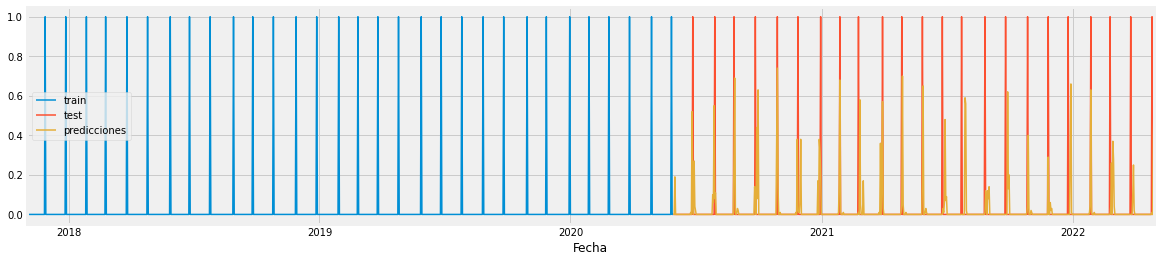

In [18]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 4))
df_train['target'].plot(ax=ax, label='train')
df_test['target'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [19]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_test['target'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.03451685714285714


In [20]:
predicciones[predicciones > 0.5]

2020-06-26    0.52
2020-07-28    0.55
2020-08-27    0.69
2020-09-30    0.63
2020-10-28    0.74
2021-01-27    0.68
2021-02-25    0.58
2021-03-30    0.57
2021-04-28    0.70
2021-05-28    0.65
2021-07-28    0.59
2021-07-29    0.56
2021-09-28    0.62
2021-12-29    0.66
2022-01-27    0.63
2022-04-29    0.59
Name: pred, dtype: float64

In [21]:
int(len(df_train)*0.5)

470

In [22]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 250
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 365 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [182, 280]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = df_train['target'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(df_train)*0.7),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:06<00:00, 33.46s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [23]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.030392,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.030715,3,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.030779,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.030935,5,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.031185,10,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.031352,5,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.033453,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.033594,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.035251,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.035513,5,100


In [24]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 365
             )

forecaster.fit(y=df_train['target'])

In [25]:
steps = 700
predicciones = forecaster.predict(steps=steps)
predicciones.head()

2020-05-30    0.007110
2020-05-31    0.001556
2020-06-01    0.178681
2020-06-02    0.008133
2020-06-03    0.002313
Freq: D, Name: pred, dtype: float64

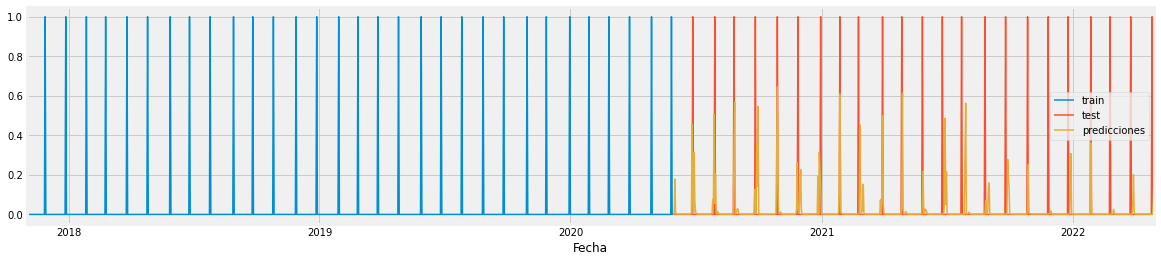

In [26]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 4))
df_train['target'].plot(ax=ax, label='train')
df_test['target'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [27]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = df_test['target'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.03155272006990315


In [28]:
predicciones[predicciones > 0.3]

2020-06-26    0.455118
2020-06-29    0.314118
2020-07-28    0.507008
2020-08-26    0.332982
2020-08-27    0.566451
2020-09-28    0.356591
2020-09-30    0.546119
2020-10-27    0.348109
2020-10-28    0.645291
2020-12-28    0.315111
2021-01-27    0.609766
2021-02-25    0.453302
2021-03-30    0.499625
2021-04-28    0.613026
2021-06-29    0.486429
2021-07-28    0.320426
2021-07-29    0.563103
2021-12-29    0.307783
2022-01-27    0.362476
Name: pred, dtype: float64